# ERC IndexThePlanet -  Unitigs cost projection for entire SRA on AWS
### Rayan Chikhi, first version 10 October 2023, updated 28 October 2023 and in November 2023 as well

## Get all jobs (=entire SRA list of accessions) and their size in megabytes (takes about a minute)

In [1]:
# prepare 
sra_metadata_filename = "/home/ec2-user/erc-unitigs-poc/Athena_Sept_19_public.acc_mbases.txt"

acc_size = dict()
with open(sra_metadata_filename) as f:
    f.readline()
    for line in f:
        acc, size = line.split()
        size = int(size)
        acc_size[acc] = size
        
print(len(acc_size),"jobs:",list(acc_size.items())[:3],"...")

26475979 jobs: [('SRR18594289', 24), ('SRR6882457', 16), ('SRR12073680', 23)] ...


## Get running times and memory usages for a previously done test run on ~5000 jobs

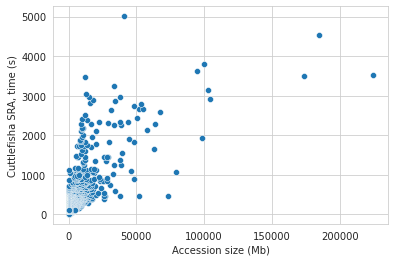

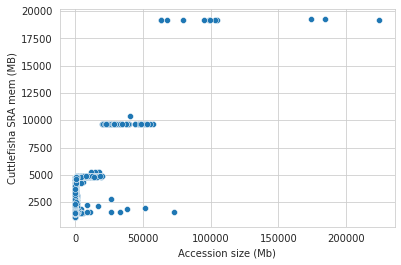

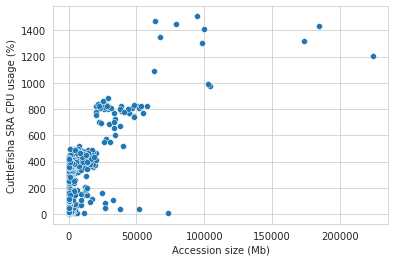

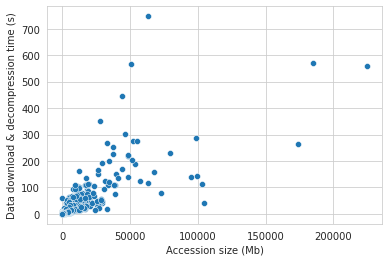

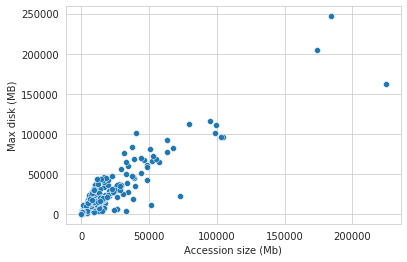

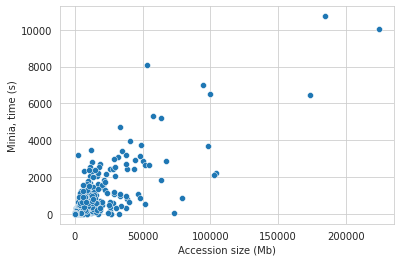

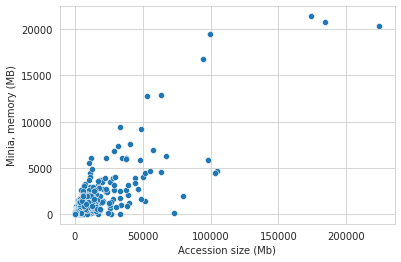

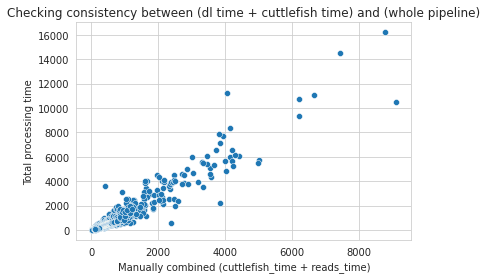

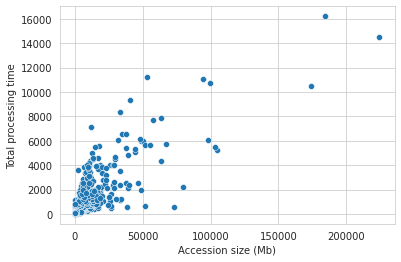

5461 samples


In [51]:
import boto3
from boto3.dynamodb.conditions import Key, Attr
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from math import log

# Initialize the SimpleDB client
client = boto3.client('sdb')

region='us-east-1'
domain_name = "serratus-batch-unitigs"

tool = 'cuttlefisha'
tool_long = 'Cuttlefisha SRA'

query_expression = f'select * from `{domain_name}` where `{tool}_x64_time` is not null'
next_token = None
records = []

while True:
    request_params = {
        'SelectExpression': query_expression,
        'ConsistentRead': True
    }
    if next_token:
        request_params['NextToken'] = next_token
    response = client.select(**request_params)
    records.extend(response['Items'])
    next_token = response.get('NextToken')
    if not next_token:
        break

parsed_items = {}
data = []
for item in records:
    item_name = item['Name']
    attributes = {attribute['Name']: attribute['Value'] for attribute in item['Attributes']}
    parsed_items[item_name] = attributes
    # Some explanations:
    # the workload consists of two steps:
    # 1) download and uncompress data (measured by erc_batch_assembly_dl_time)
    # 2) creating the assemblies (measured by cuttlefisha_x64_time)
    # the sum of both should roughly match the total workload time (x64_processing_time)
    keys = {
        f'{tool}_x64_time': 'cuttlefish_time',
        f'{tool}_x64_mem': 'cuttlefish_mem',
        f'{tool}_x64_percent_cpu': 'cuttlefish_pcpu',
        'reads_time': 'reads_time',
        'reads_sra_time': 'reads_sra_time',
        'x64_processing_time': 'x64_processing_time',
        'x64_return_value': 'x64_return_value',
        'x64_max_disk': 'x64_max_disk',
        'minia_x64_time': 'minia_time',
        'minia_x64_mem': 'minia_mem',
    }
    variables_dict = {}
    for original_key, variable_name in keys.items():
        if original_key in parsed_items[item_name]:
            variables_dict[variable_name] = float(parsed_items[item_name][original_key])
        else:
            variables_dict[variable_name] = None
    if all(value is not None for value in variables_dict.values()):
        data += [tuple([item_name, acc_size[item_name]]) + tuple([variables_dict[var] for var in keys.values()])]

df = pd.DataFrame(data, columns=['item_name', 'acc_size', 'cuttlefish_time', 'cuttlefish_mem', 'cuttlefish_pcpu', 'reads_time', 'reads_sra_time', 'x64_processing_time', 'x64_return_value', 'x64_max_disk', 'minia_time', 'minia_mem'])

# Filter the dataframe, don't analyze failed runs
df = df[df['x64_return_value'] == 0]

# Plot directly from the main DataFrame
sns.set_style("whitegrid")
sns.scatterplot(x="acc_size", y="cuttlefish_time", data=df)
plt.xlabel("Accession size (Mb)")
plt.ylabel(f"{tool_long}, time (s)")
plt.show()

sns.scatterplot(x="acc_size", y="cuttlefish_mem", data=df)
plt.xlabel("Accession size (Mb)")
plt.ylabel(f"{tool_long} mem (MB)")
plt.show()

sns.scatterplot(x="acc_size", y="cuttlefish_pcpu", data=df)
plt.xlabel("Accession size (Mb)")
plt.ylabel(f"{tool_long} CPU usage (%)")
plt.show()

sns.scatterplot(x="acc_size", y="reads_sra_time", data=df)
plt.xlabel("Accession size (Mb)")
plt.ylabel("Data download & decompression time (s)")
plt.show()

sns.scatterplot(x="acc_size", y="x64_max_disk", data=df)
plt.xlabel("Accession size (Mb)")
plt.ylabel("Max disk (MB)")
plt.show()

sns.scatterplot(x="acc_size", y="minia_time", data=df)
plt.xlabel("Accession size (Mb)")
plt.ylabel(f"Minia, time (s)")
plt.show()

sns.scatterplot(x="acc_size", y="minia_mem", data=df)
plt.xlabel("Accession size (Mb)")
plt.ylabel(f"Minia, memory (MB)")
plt.show()


df['combined_time'] = df['cuttlefish_time'] + df['reads_time']
sns.scatterplot(x='combined_time', y='x64_processing_time', data=df)
plt.title('Checking consistency between (dl time + cuttlefish time) and (whole pipeline)')
plt.xlabel('Manually combined (cuttlefish_time + reads_time)')
plt.ylabel('Total processing time')
plt.show()

sns.scatterplot(x='acc_size', y='x64_processing_time', data=df)
plt.xlabel("Accession size (Mb)")
plt.ylabel('Total processing time')
plt.show()

print(len(data),"samples")

## Make a simple machine learning model (linear regression) to predict running time for all jobs

In [47]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from scipy import stats

# Extract columns directly from the DataFrame
X = df['acc_size'].tolist()

# Compute the sum of the two columns for each row
y = (df['x64_processing_time']).tolist()

X = np.array(X).reshape(-1, 1)
y = np.array(y)
print(X,y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize a linear regression model
regressor = LinearRegression()

# Fit the model to the training data
regressor.fit(X_train, y_train)

# Predict the running time on the test set
y_pred = regressor.predict(X_test)

# Evaluate the model's performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

dataset_sizes = list(acc_size.values())
X_full  = np.array(dataset_sizes).reshape(-1, 1)
predicted_running_times = regressor.predict(X_full )
total_running_time_seconds = sum(predicted_running_times)
print("Estimated total running time:",'{:,}'.format(int(total_running_time_seconds/60/60)),"wall-clock hours")

# Now compute confidence intervals

# Compute the standard error of the regression
residuals = y_train - regressor.predict(X_train)
std_error = residuals.std()

# Compute the quantile from the t-distribution for the desired confidence level
alpha=0.05
t_value = stats.t.ppf(1 - alpha/2, len(y_train) - 2)  # df = n - 2 for simple linear regression

# Calculate the confidence interval's margin for each prediction
margin = t_value * std_error * np.sqrt(1/len(X_train) + (X_full - X_train.mean())**2 / np.sum((X_train - X_train.mean())**2))

lower_bounds = predicted_running_times - margin.squeeze()
upper_bounds = predicted_running_times + margin.squeeze()

total_running_time_seconds_lb = sum(lower_bounds)
total_running_time_seconds_ub = sum(upper_bounds)
print(f"Confidence interval: {total_running_time_seconds_lb/60/60:,} - {total_running_time_seconds_ub/60/60:,}")

[[   1]
 [   0]
 [   1]
 ...
 [ 131]
 [1614]
 [1183]] [ 11.  11.  11. ... 103. 212. 152.]
Mean Squared Error: 256235.66682227515
R^2 Score: 0.6224043146804338
Estimated total running time: 1,999,173 wall-clock hours
Confidence interval: 1,889,682.881441006 - 2,108,663.668492484



## Separate jobs into those that will use > 8 GB mem and those < 8 GB

In [48]:
#threshold = df[df['minia_mem'] > 8000]['acc_size'].min()
#if threshold != 'nan': 
#    threshold = df['acc_size'].max()
#else:
#    threshold = int(threshold)

def predict_runtimes(dataset_sizes):
    threshold1 = 20000
    threshold2 = 60000 

    lowmem = [size for size in dataset_sizes if size < threshold1]
    midmem = [size for size in dataset_sizes if size >= threshold1 and size < threshold2]
    highmem = [size for size in dataset_sizes if size >= threshold2]

    lowmem_running_time_seconds  = sum(regressor.predict(np.array(lowmem) .reshape(-1, 1)))
    midmem_running_time_seconds  = sum(regressor.predict(np.array(midmem) .reshape(-1, 1)))
    highmem_running_time_seconds = sum(regressor.predict(np.array(highmem).reshape(-1, 1)))
    return lowmem_running_time_seconds, midmem_running_time_seconds, highmem_running_time_seconds
    
lowmem_running_time_seconds, midmem_running_time_seconds, highmem_running_time_seconds = predict_runtimes(dataset_sizes)
print(f"{int(lowmem_running_time_seconds/60/60):,} wall-clock hours at 8gb")
print(f"{int(midmem_running_time_seconds/60/60):,} wall-clock hours at 15gb")
print(f"{int(highmem_running_time_seconds/60/60):,} wall-clock hours at 31gb")

1,591,594 wall-clock hours at 8gb
195,254 wall-clock hours at 15gb
212,324 wall-clock hours at 31gb


## Estimate lower bound of compute costs (if Batch scheduling was perfect, but it's not)

In [49]:
import boto3
import json

def get_aws_price(service_code, field, value, region='us-east-1', product_family=None):
    client = boto3.client('pricing', region_name='us-east-1')
    
    filters = [
        {'Type': 'TERM_MATCH', 'Field': field, 'Value': value},
        {'Type': 'TERM_MATCH', 'Field': 'location', 'Value': region_to_location(region)}
    ]

    if product_family:
        filters.append({'Type': 'TERM_MATCH', 'Field': 'productFamily', 'Value': product_family})

    response = client.get_products(
        ServiceCode=service_code,
        Filters=filters,
        MaxResults=100
    )
    
    for product_str in response['PriceList']:
        product = json.loads(product_str)
        attributes = product['product']['attributes']
        
        os = attributes.get('operatingSystem')
        software = attributes.get('preInstalledSw')

        # Specifically check for Linux without additional software
        if service_code == 'AmazonEC2' and os == 'Linux' and software == 'NA':
            for term in product['terms']['OnDemand']:
                for price_dimension in product['terms']['OnDemand'][term]['priceDimensions'].values():
                    price = float(price_dimension['pricePerUnit']['USD'])
                    if price > 0:
                        return price

        if service_code == 'AmazonEC2' and product_family == 'Storage' and attributes.get('volumeApiName') == value:
            for term in product['terms']['OnDemand']:
                for price_dimension in product['terms']['OnDemand'][term]['priceDimensions'].values():
                    return float(price_dimension['pricePerUnit']['USD'])
    print("failed to get price for",service_code,field,value,product_family)
    return None

def region_to_location(region):
    return {
        'us-east-1': 'US East (N. Virginia)'
        # Add other regions as needed
    }.get(region)

# EC2 Cost
# aiming for c5.4xlarge
hourly_price = 0.2364 # spot price given by Maxime


def predict_costs(lowmem_running_time_seconds, midmem_running_time_seconds, highmem_running_time_seconds):
    lowmem_cost_for_seconds  = (hourly_price / 4) *  (lowmem_running_time_seconds/ 3600)
    midmem_cost_for_seconds  = (hourly_price / 2) *  (midmem_running_time_seconds/ 3600)
    highmem_cost_for_seconds = (hourly_price / 1) * (highmem_running_time_seconds/ 3600)

    # EBS Cost
    volume_type = 'gp3'
    monthly_price_per_gb = get_aws_price('AmazonEC2', 'volumeApiName', 'gp3', product_family='Storage')
    #print("EBS monthly price per gb",monthly_price_per_gb)
    # Throughput charge: 125 MB/s free and $0.040/provisioned MB/s-month over 125
    throughput_extra =  0.04 * 475
    def hourly_cost_for_ebs(size):
        monthly_cost_for_ebs = monthly_price_per_gb * size  + throughput_extra
        return monthly_cost_for_ebs/30/24

    ebs_costs = hourly_cost_for_ebs(20*4) *   (lowmem_running_time_seconds/60/60) + \
                hourly_cost_for_ebs(20*8) *   (midmem_running_time_seconds/60/60) + \
                hourly_cost_for_ebs(20*16) * (highmem_running_time_seconds/60/60) 
    print("-----Breakdown:")
    print(f'Cost for running low-mem jobs for {int(lowmem_running_time_seconds/60/60):,} hours: ${lowmem_cost_for_seconds:.2f}')
    print(f'Cost for running mid-mem jobs for {int(midmem_running_time_seconds/60/60):,} hours: ${midmem_cost_for_seconds:.2f}')
    print(f'Cost for running high-mem jobs for {int(highmem_running_time_seconds/60/60):,} hours: ${highmem_cost_for_seconds:.2f}')
    print(f'Cost for EBS {int((lowmem_running_time_seconds+midmem_running_time_seconds+highmem_running_time_seconds)/60/60):,} hours, 20 GB per vCPU: ${ebs_costs:.2f}')
    print("-----:")
    print(f"Total if all is scheduled perfectly: ${ebs_costs+highmem_cost_for_seconds+midmem_cost_for_seconds+lowmem_cost_for_seconds:.2f}")
    
predict_costs(lowmem_running_time_seconds, midmem_running_time_seconds, highmem_running_time_seconds)
# estimation in Alpine+regular EBS Throughput (i.e. prior to Ubunbu+Throughput 250MB/s):
#-----Breakdown:
#Cost for running c6a.2xlarge for 1,258,818 hours: $227846.11
#Cost for running c6a.4xlarge for 547,296 hours: $193633.63
#Cost for EBS 1,806,115 hours, 1 TB: $205495.77
#-----Total:
#Total: $626975.51

-----Breakdown:
Cost for running low-mem jobs for 1,591,594 hours: $94063.21
Cost for running mid-mem jobs for 195,254 hours: $23079.07
Cost for running high-mem jobs for 212,324 hours: $50193.57
Cost for EBS 1,999,173 hours, 20 GB per vCPU: $77923.98
-----:
Total if all is scheduled perfectly: $245259.83


## Why so low?? Let's compare to the previous estimation

In [30]:
# estimation in April 2023
nb_samples = len(acc_size)
cost_per_3000 = 145 # dollars
print(f"145$ for old run on 3,000 samples, extrapolated to {nb_samples:,} samples -> {int(nb_samples * cost_per_3000 / 3000):,} dollars")

# estimation from recent runs over 5000 samples
cost = 145 # dollars
volume = 9173188 # mbytes
volume *= 0.85 # observed workload success rate for various reasons (random batch failure, out of mem, etc)
sra_volume = 47016269164
print(f"{cost}$ for newer run over {volume:,} mbytes, extrapolated to {sra_volume:,} mbytes -> {int(cost * sra_volume / volume):,} dollars")

145$ for old run on 3,000 samples, extrapolated to 26,475,979 samples -> 1,279,672 dollars
145$ for newer run over 7,797,209.8 mbytes, extrapolated to 47,016,269,164 mbytes -> 874,333 dollars


## Possible factor 1: massive reduction in download time due to SRA-lite processing

In [19]:
# Initialize the SimpleDB client
client = boto3.client('sdb')
region='us-east-1'
domain_name = "serratus-batch-unitigs"
query_expression = 'select * from `{}` where `pfqdump_time` is not null and `fqdump_time` is not null and `cuttlefish_x64_time` is not null'.format(domain_name)
next_token = None
records = []

while True:
    request_params = {
        'SelectExpression': query_expression,
        'ConsistentRead': True
    }
    if next_token:
        request_params['NextToken'] = next_token
    response = client.select(**request_params)
    records.extend(response['Items'])
    next_token = response.get('NextToken')
    if not next_token:
        break

# Print the items from the response
parsed_items = {}
data = []
for item in records:
    item_name = item['Name']
    attributes = {attribute['Name']: attribute['Value'] for attribute in item['Attributes']}
    parsed_items[item_name] = attributes
    if 'batch_assembly_dl_time' in parsed_items[item_name]:
        batch_assembly_dl_time = float(parsed_items[item_name]['batch_assembly_dl_time'])
    if 'erc_batch_assembly_dl_time' in parsed_items[item_name]:
        erc_batch_assembly_dl_time = float(parsed_items[item_name]['erc_batch_assembly_dl_time'])
    if 'cuttlefish_x64_time' in parsed_items[item_name]:
        cuttlefish_x64_time = float(parsed_items[item_name]['cuttlefish_x64_time'])
    if x64_return_value == 0 and item_name in acc_size:
        data += [(item_name, batch_assembly_dl_time, erc_batch_assembly_dl_time, cuttlefish_x64_time, acc_size[item_name])]

previous_dl_time = sum([x[1] for x in data])
new_dl_time = sum([x[2] for x in data])
old_total_time = sum([data[i][1]+data[i][3] for i in range(len(data))])
new_total_time = sum([data[i][2]+data[i][3] for i in range(len(data))])
print(f"on {len(data)} accessions, totalling {sum(x[-1] for x in data):,} mbytes")
print("Previous total download+decomp time:",previous_dl_time)
print("New total download+decomp time:",new_dl_time)
print(f"Reduction over download+decomp time only: {(previous_dl_time-new_dl_time)/previous_dl_time*100.0:.1f}%")
print(f"Reduction over total time of workload (download+decompression+cuttlefish): {(old_total_time-new_total_time)/old_total_time*100.0:.1f}%")

print(f"New cost estimation of 1,279,672 dollars figure considering a 28.1% improvement: {int(1279672*(1-0.281)):,} dollars")

NameError: name 'x64_return_value' is not defined

## Factor 2: confidence interval on running times estimation

In [112]:
revised = (lowmem_cost_for_seconds+highmem_cost_for_seconds)
up_factor   = total_running_time_seconds_ub/total_running_time_seconds
down_factor = total_running_time_seconds_lb/total_running_time_seconds
"revised cost confidence interval: "+f"{revised*down_factor:.1f} - {revised*up_factor:.1f}"+"$"

'revised cost confidence interval: 401438.9 - 441520.6$'

## Estimate total disk space of output

In [58]:
#]$ aws s3 ls s3://serratus-rayan/indextheplanet-unitigs-poc/ --recursive |grep fa$ |awk '{s+=$3} END {print s}'
# ou just: --summarize |tail 
#space_on_sample = 1324451028507 # bytes, uncompressed
space_on_sample = 543603300541 # bytes, compressed
volume = 9173188 # mbases
sra_volume = 47016269164 # mbases
int((space_on_sample * sra_volume / volume) / 1024 / 1024 / 1024 / 1024 / 1024),"petabytes"
# Artem 100% wants FASTA on open data, but Guillaume suggests to zstd

(2, 'petabytes')

## Predicting cost of subsets

In [50]:
import os
import csv
folder_path = '/home/ec2-user/erc-unitigs-poc/subsets/'
tsv_files = [f for f in os.listdir(folder_path) if f.endswith('.tsv')]
all_second_columns = []
for tsv_file in tsv_files:
    with open(os.path.join(folder_path, tsv_file), newline='', encoding='utf-8') as file:
        reader = csv.reader(file, delimiter='\t')
        second_column = [int(row[1]) for row in reader if row and row[1].isdigit()]  # ensure the row is not empty
    all_second_columns.extend(second_column)
dataset_sizes = all_second_columns
lowmem_running_time_seconds, midmem_running_time_seconds, highmem_running_time_seconds = predict_runtimes(dataset_sizes)
print(f"{int(lowmem_running_time_seconds/60/60):,} wall-clock hours at 8gb")
print(f"{int(midmem_running_time_seconds/60/60):,} wall-clock hours at 15gb")
print(f"{int(highmem_running_time_seconds/60/60):,} wall-clock hours at 31gb")

330 wall-clock hours at 8gb
40 wall-clock hours at 15gb
32 wall-clock hours at 31gb


## More realistic cost estimation using instances, for a good run between Nov 2 evening and Nov 3 afternoon

In [262]:
import boto3
from datetime import datetime, timedelta
import pandas as pd
import json
from datetime import datetime
from collections import defaultdict
import time
client = boto3.client('cloudtrail')

def get_ec2_events(event_name, start_time, end_time):
    events = []
    next_token = None  # Initialize the NextToken variable
    while True:  # Continue looping until break is called
        params = {
            "LookupAttributes": [
                {   'AttributeKey': 'EventName',
                    'AttributeValue': event_name, }, ],
            "MaxResults": 50,
            "StartTime": start_time,
            "EndTime": end_time,
        }
        if next_token:
            params["NextToken"] = next_token  # Only include NextToken if it's not None or empty
        response = client.lookup_events(**params)
        #print(response)
        for event in response['Events']:
            events += [event]
        next_token = response.get('NextToken')  # Get the NextToken from the response
        if not next_token:
            break  # Exit the loop if there is no 
    return events

def get_termination_times(terminate_instances):
    termination_times = defaultdict(list)
    for log in terminate_instances:
        cloud_trail_event = json.loads(log['CloudTrailEvent'])
        # Extracting instance details
        instance_id = cloud_trail_event['requestParameters']['instancesSet']['items'][0]['instanceId']
        termination_time = datetime.strptime(cloud_trail_event['eventTime'], '%Y-%m-%dT%H:%M:%SZ')
        termination_times[instance_id].append(termination_time)
    return termination_times
    
def get_creation_times(run_instances):
    creation_times = defaultdict(list)
    for log in run_instances:
        cloud_trail_event = json.loads(log['CloudTrailEvent'])
        if cloud_trail_event.get('responseElements') and cloud_trail_event['responseElements'].get('instancesSet'):
            items = cloud_trail_event['responseElements']['instancesSet'].get('items', [])
            for item in items:
                # Extracting instance details
                instance_id = item.get('instanceId')
                creation_time_str = str(item.get('launchTime'))
                instance_type = item.get('instanceType')
                if instance_id and creation_time_str:
                    if isinstance(creation_time_str, (int, str)) and creation_time_str.isdigit():
                        creation_time = datetime.utcfromtimestamp(int(creation_time_str) / 1000)
                    else:
                        print(f'Unexpected format for launchTime: {creation_time_str}')
                        continue  # Skip to the next iteration
                    creation_times[instance_id].append((creation_time, instance_type))
    return creation_times

start_time = datetime(2023, 11, 2, 23, 0)
end_time = datetime(2023, 11, 3, 15, 59)
recalculate_times = True # activate this if you want to recalculate 
if recalculate_times:
    creation_times    = get_creation_times(   get_ec2_events('RunInstances',       start_time, end_time))
    termination_times = get_termination_times(get_ec2_events('TerminateInstances', start_time, end_time))
    

print(len(creation_times), "creations", len(termination_times), "terminations")

aws_pricing = { # per hour
    'c5.metal': 1.6349,
    'c5.24xlarge': 1.3010,
    'c5.18xlarge': 1.2223,
    'c5.12xlarge': 0.8294,
    'c5.9xlarge': 0.6200,
    'c5.4xlarge': 0.2392,
}

def calculate_cost(instance_type, duration):
    duration_hours = duration.total_seconds() / 3600
    hourly_rate = aws_pricing[instance_type]
    return hourly_rate * duration_hours

columns = ['Instance ID', 'Instance Type', 'Creation Time', 'Termination Time', 'Duration (HH:MM:SS)', 'Cost (USD)']
df = pd.DataFrame(columns=columns)

for instance_id, creation_data in creation_times.items():
    if instance_id in termination_times:
        creation_time, instance_type = creation_data[0]
        termination_time = termination_times[instance_id][0]
        if creation_time < termination_time:
            duration = termination_time - creation_time
            cost = calculate_cost(instance_type, duration)
            df = df.append({
                'Instance ID': instance_id,
                'Instance Type': instance_type,
                'Creation Time': creation_time,
                'Termination Time': termination_time,
                'Duration (HH:MM:SS)': str(duration),
                'Cost (USD)': cost
            }, ignore_index=True)

# Display the DataFrame
print(df)
print(f"Total EC2 instance cost for time period {start_time} to {end_time}:")
print(f"{df['Cost (USD)'].sum():.2f}$")

157 creations 676 terminations
             Instance ID Instance Type       Creation Time  \
0    i-0ba162911017be93d      c5.metal 2023-11-03 09:42:11   
1    i-03492539fab5cc8b1    c5.4xlarge 2023-11-03 09:42:03   
2    i-04a22b10e520bdb05    c5.4xlarge 2023-11-03 09:42:02   
3    i-055e9c32eacf226f8    c5.4xlarge 2023-11-03 09:42:02   
4    i-0c12c72833daedf61    c5.4xlarge 2023-11-03 09:42:01   
..                   ...           ...                 ...   
150  i-0c023f69647acb8ac    c5.4xlarge 2023-11-02 23:14:49   
151  i-09a7e3fc431d8e316    c5.4xlarge 2023-11-02 23:14:49   
152  i-050f2649043732ee3    c5.4xlarge 2023-11-02 23:14:49   
153  i-04f2f53046e58b675      c5.metal 2023-11-02 23:14:49   
154  i-0c0f7f74bda49ffd0      c5.metal 2023-11-02 23:09:09   

       Termination Time Duration (HH:MM:SS)  Cost (USD)  
0   2023-11-03 09:46:25             0:04:14    0.115351  
1   2023-11-03 09:44:16             0:02:13    0.008837  
2   2023-11-03 09:44:16             0:02:14    0.0

## Misc data exploration

In [176]:
df[df['acc_size'] < 5000]

item_name  acc_size  cuttlefisha_time  cuttlefisha_mem  \
0     SRR14942100         4         10.001405      4595.593750   
1     SRR23313691         6         10.001815      4637.984375   
2     SRR11499859         3         10.003639      4619.593750   
3      SRR8846602         9         10.014869      4634.890625   
4      ERR1084017         0         10.021188      4561.328125   
...           ...       ...               ...              ...   
5477   SRR7237168      2017         98.758825     11730.125000   
5478  SRR18693291      1930         98.950996     11728.375000   
5479   SRR6762476      2117         99.533187     11731.515625   
5480  SRR24942988       619         99.735850     11728.562500   
5481  SRR11998443      2471         99.894371     11747.328125   

      cuttlefisha_pcpu  erc_batch_assembly_dl_time  x64_processing_time  \
0                110.0                         3.0                 14.0   
1                112.0                         3.0                 13.0   
2                117.0                         2.0                 12.0   
3                127.0                         4.0                 14.0   
4                104.0                         0.0                 11.0   
...                ...                         ...                  ...   
5477             751.0                       100.0                201.0   
5478             752.0                       154.0                256.0   
5479             772.0                        73.0                174.0   
5480             751.0                        23.0                125.0   
5481             436.0                        58.0                164.0   

      x64_return_value  x64_max_disk  combined_time  
0                  0.0          25.0      13.001405  
1                  0.0          27.0      13.001815  
2                  0.0          29.0      12.003639  
3                  0.0          32.0      14.014869  
4                  0.0          20.0      10.021188  
...                ...           ...            ...  
5477               0.0        4522.0     198.758825  
5478               0.0        4601.0     252.950996  
5479               0.0        5603.0     172.533187  
5480               0.0        2880.0     122.735850  
5481               0.0        4864.0     157.894371  

[5064 rows x 10 columns]

In [74]:
df[df['acc_size'] == df[df['minia_time'] > 3000]['acc_size'].min()]

item_name  acc_size  cuttlefish_time  cuttlefish_mem  cuttlefish_pcpu  \
5362  SRR7215016      4639        924.06269     2942.367188            434.0   

      reads_time  reads_sra_time  x64_processing_time  x64_return_value  \
5362        90.0            12.0               2069.0               0.0   

      x64_max_disk   minia_time    minia_mem  combined_time  
5362       14521.0  3365.277344  3365.277344     1014.06269

In [258]:
# debugging
#start_time = datetime(2023, 10, 31, 9, 56)
#end_time = datetime(2023, 10, 31, 10, 10)
start_time = datetime(2023, 11, 4, 12, 20)
end_time = datetime(2023, 11, 4, 12, 50)
params = {
    "LookupAttributes": [  {   'AttributeKey': 'EventName',       'AttributeValue': 'RunInstances', }, ],
    "MaxResults": 50,
    "StartTime": start_time,
    "EndTime": end_time,
}
client = boto3.client('cloudtrail')
print(get_creation_times(   get_ec2_events('RunInstances',       start_time, end_time)))
print(get_termination_times(get_ec2_events('TerminateInstances', start_time, end_time)))


defaultdict(<class 'list'>, {'i-02493e4f795cdd003': [(datetime.datetime(2023, 11, 4, 12, 49, 4), 'c5.metal')], 'i-0128e8b0daf5481e2': [(datetime.datetime(2023, 11, 4, 12, 48, 55), 'c5.4xlarge')], 'i-04d8ea615c182f472': [(datetime.datetime(2023, 11, 4, 12, 35, 7), 'c5.4xlarge')]})
defaultdict(<class 'list'>, {'i-04d8ea615c182f472': [datetime.datetime(2023, 11, 4, 12, 39, 13)], 'i-0cea41fe21b390955': [datetime.datetime(2023, 11, 4, 12, 23, 7)]})
